In [ ]:
# Mounting Google Drive
# This cell correctly mounts Google Drive to access datasets stored in Google Colab.
# Simple and essential step for data loading.

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# ✅ Final Safe Extraction Code for cats_vs_dogs_small.zip

import os
import zipfile

zip_path = "/content/cats_vs_dogs_small.zip"
extract_to = "/content"
target_dir = os.path.join(extract_to, "cats_vs_dogs_small")

#  Check if the folder already exists ---
if os.path.exists(target_dir):
    print("✅ Dataset folder already exists — skipping extraction.")
else:
    #  Check if the ZIP file actually exists ---
    if not os.path.exists(zip_path):
        raise FileNotFoundError(f"❌ ZIP file not found at: {zip_path}")


    try:
        with zipfile.ZipFile(zip_path, "r") as zip_ref:
            print("🔍 Verifying ZIP file integrity...")
            bad_file = zip_ref.testzip()
            if bad_file:
                raise zipfile.BadZipFile(f"Corrupted file found inside ZIP: {bad_file}")

            print("🔄 Extracting dataset... please wait.")
            zip_ref.extractall(extract_to)
            print("✅ Extraction complete!")

    except zipfile.BadZipFile:
        raise zipfile.BadZipFile("❌ The provided file is not a valid ZIP archive. "
                                 "Please re-upload a proper ZIP file.")

if os.path.exists(target_dir):
    print("\n📂 Dataset structure:")
    for root, dirs, files in os.walk(target_dir):
        level = root.replace(target_dir, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print(f"{indent}{os.path.basename(root)}/")
        subindent = ' ' * 4 * (level + 1)
        for f in files[:5]:  # Show first few files per folder
            print(f"{subindent}{f}")
else:
    print("❌ Extraction failed: Dataset folder not found.")



✅ Dataset folder already exists — skipping extraction.

📂 Dataset structure:
cats_vs_dogs_small/
    validation/
        cats/
            1004.jpg
            1033.jpg
            1392.jpg
            1425.jpg
            1191.jpg
        dogs/
            1004.jpg
            1033.jpg
            1392.jpg
            1425.jpg
            1191.jpg
    train/
        cats/
            168.jpg
            289.jpg
            707.jpg
            349.jpg
            957.jpg
        dogs/
            168.jpg
            289.jpg
            707.jpg
            349.jpg
            957.jpg
    test/
        cats/
            1548.jpg
            1853.jpg
            1520.jpg
            1948.jpg
            1795.jpg
        dogs/
            1548.jpg
            1853.jpg
            1520.jpg
            1948.jpg
            1795.jpg


In [ ]:
# Verify that train, validation, and test folders exist
import os

base_dir = "/content/cats_vs_dogs_small"
train_dir = os.path.join(base_dir, "train")
validation_dir = os.path.join(base_dir, "validation")
test_dir = os.path.join(base_dir, "test")

print("Contents of base directory:", os.listdir(base_dir))
print("\nTraining folders:", os.listdir(train_dir))
print("\nValidation folders:", os.listdir(validation_dir))
print("\nTest folders:", os.listdir(test_dir))


Contents of base directory: ['validation', 'train', 'test']

Training folders: ['cats', 'dogs']

Validation folders: ['cats', 'dogs']

Test folders: ['cats', 'dogs']


In [ ]:
# Install TensorFlow if needed
!pip install -q tensorflow


In [ ]:
# Import all necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, applications


In [ ]:
# Load train, validation, and test datasets efficiently

train_dir = "/content/cats_vs_dogs_small/train"
validation_dir = "/content/cats_vs_dogs_small/validation"
test_dir = "/content/cats_vs_dogs_small/test"

ds_train = keras.utils.image_dataset_from_directory(
    train_dir, image_size=(180, 180), batch_size=32
)
ds_val = keras.utils.image_dataset_from_directory(
    validation_dir, image_size=(180, 180), batch_size=32
)
ds_test = keras.utils.image_dataset_from_directory(
    test_dir, image_size=(180, 180), batch_size=32
)


Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


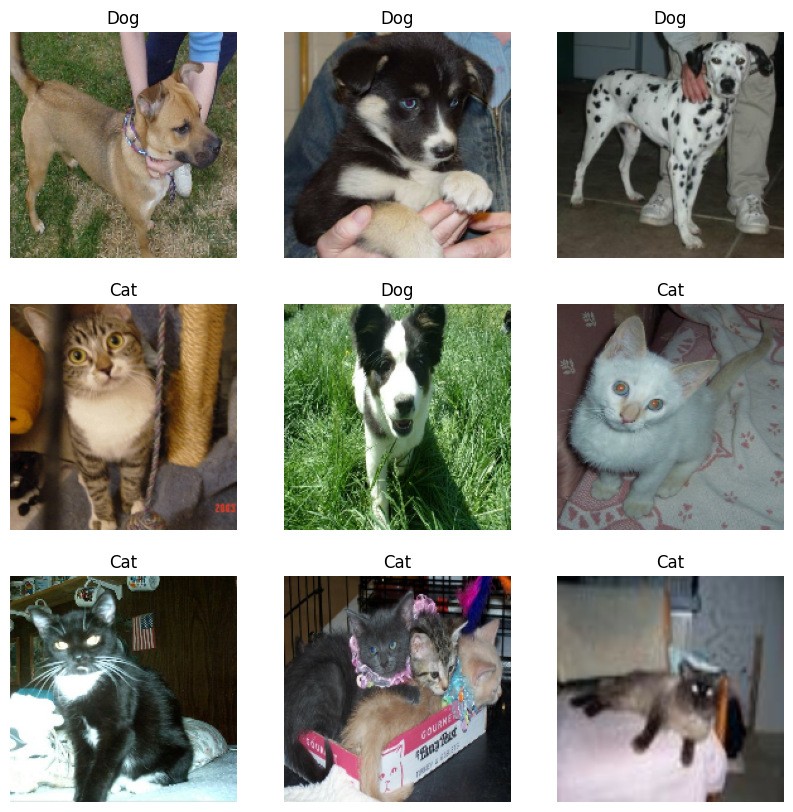

In [ ]:
# Display sample images from training set
def show_images(dataset):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title("Cat" if labels[i] == 0 else "Dog")
            plt.axis("off")
    plt.show()

show_images(ds_train)


In [ ]:
# Define a simple CNN model
def build_custom_model():
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=(180,180,3)),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
# Create augmented data generators for training/validation
def prepare_data_flows(training_path, validation_path, batch_size):
    train_datagen = keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    val_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

    gen_train = train_datagen.flow_from_directory(
        training_path, target_size=(180,180),
        batch_size=batch_size, class_mode='binary'
    )
    gen_val = val_datagen.flow_from_directory(
        validation_path, target_size=(180,180),
        batch_size=batch_size, class_mode='binary'
    )
    return gen_train, gen_val


In [ ]:
# Generic training function
def fit_model(model, gen_train, gen_val, epochs=30):
    history = model.fit(gen_train, validation_data=gen_val, epochs=epochs)
    return history


In [ ]:
train_generator_1, validation_generator_1 = prepare_data_flows(
    "/content/cats_vs_dogs_small/train",
    "/content/cats_vs_dogs_small/validation",
    batch_size=32
)
model_A = build_custom_model()
history_A = fit_model(model_A, train_generator_1, validation_generator_1)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 30s 376ms/step - accuracy: 0.4872 - loss: 1.3191 - val_accuracy: 0.5170 - val_loss: 0.6920
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 351ms/step - accuracy: 0.5314 - loss: 0.6921 - val_accuracy: 0.5000 - val_loss: 0.6922
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 324ms/step - accuracy: 0.5065 - loss: 0.6930 - val_accuracy: 0.5240 - val_loss: 0.6916
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 312ms/step - accuracy: 0.5017 - loss: 0.6921 - val_accuracy: 0.5980 - val_loss: 0.6826
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 322ms/step - accuracy: 0.5574 - loss: 0.6900 - val_accuracy: 0.6460 - val_loss: 0.6684
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 308ms/step - accuracy: 0.5844 - loss: 0.6783 - val_accuracy: 0.6110 - val_loss: 0.6615
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 308ms/step - accuracy: 0.6020 - loss: 0.6695 - val_accuracy: 0.6780 - val_loss: 0.6286
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 310ms/step - accuracy: 0.6039 - loss: 0.6593 - val_accu

In [ ]:
train_generator_2, validation_generator_2 = prepare_data_flows(
    "/content/cats_vs_dogs_small/train",
    "/content/cats_vs_dogs_small/validation",
    batch_size=32
)
model_B = build_custom_model()
history_B = fit_model(model_B, train_generator_2, validation_generator_2)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 25s 361ms/step - accuracy: 0.4807 - loss: 0.9352 - val_accuracy: 0.5010 - val_loss: 0.6929
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 324ms/step - accuracy: 0.5197 - loss: 0.6929 - val_accuracy: 0.5150 - val_loss: 0.6904
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 313ms/step - accuracy: 0.5180 - loss: 0.6906 - val_accuracy: 0.5360 - val_loss: 0.8078
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 327ms/step - accuracy: 0.5351 - loss: 0.6950 - val_accuracy: 0.5850 - val_loss: 0.6748
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 309ms/step - accuracy: 0.5697 - loss: 0.6796 - val_accuracy: 0.5670 - val_loss: 0.6946
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 324ms/step - accuracy: 0.5921 - loss: 0.6776 - val_accuracy: 0.6530 - val_loss: 0.6324
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 313ms/step - accuracy: 0.6402 - loss: 0.6590 - val_accuracy: 0.5240 - val_loss: 0.7519
Epoch 8/30
63

In [ ]:
train_generator_3, validation_generator_3 = prepare_data_flows(
    "/content/cats_vs_dogs_small/train",
    "/content/cats_vs_dogs_small/validation",
    batch_size=32
)
model_C = build_custom_model()
history_C = fit_model(model_C, train_generator_3, validation_generator_3)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 25s 355ms/step - accuracy: 0.4942 - loss: 0.8455 - val_accuracy: 0.5000 - val_loss: 0.6881
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 310ms/step - accuracy: 0.5300 - loss: 0.6932 - val_accuracy: 0.5150 - val_loss: 0.6928
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 321ms/step - accuracy: 0.4975 - loss: 0.6933 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 308ms/step - accuracy: 0.4724 - loss: 0.6936 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 333ms/step - accuracy: 0.5147 - loss: 0.6934 - val_accuracy: 0.5090 - val_loss: 0.6929
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 329ms/step - accuracy: 0.5144 - loss: 0.6926 - val_accuracy: 0.5690 - val_loss: 0.6807
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 312ms/step - accuracy: 0.5321 - loss: 0.6910 - val_accuracy: 0.5600 - val_loss: 0.6836
Epoch 8/30
63

In [ ]:
from tensorflow.keras import applications

def build_pretrained_model():
    base_model = applications.VGG16(include_top=False, weights='imagenet', input_shape=(180,180,3))
    base_model.trainable = False
    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
model_P1 = build_pretrained_model()
history_P1 = fit_model(model_P1, train_generator_1, validation_generator_1)

model_P2 = build_pretrained_model()
history_P2 = fit_model(model_P2, train_generator_2, validation_generator_2)

model_P3 = build_pretrained_model()
history_P3 = fit_model(model_P3, train_generator_3, validation_generator_3)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 43s 524ms/step - accuracy: 0.5836 - loss: 1.7011 - val_accuracy: 0.8830 - val_loss: 0.2891
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 25s 391ms/step - accuracy: 0.8691 - loss: 0.3327 - val_accuracy: 0.8930 - val_loss: 0.2692
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 25s 393ms/step - accuracy: 0.8284 - loss: 0.3742 - val_accuracy: 0.8820 - val_loss: 0.2662
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 25s 391ms/step - accuracy: 0.8548 - loss: 0.3331 - val_accuracy: 0.8560 - val_loss: 0.3234
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 377ms/step - accuracy: 0.8629 - loss: 0.3147 - val_accuracy: 0.9030 - val_loss: 0.2314
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 374ms/step - accuracy: 0.8598 - loss: 0.3029 - val_accuracy: 0.8980 - val_loss: 0.2305
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 381ms/step - accuracy: 0.8796 - loss: 0.2926 - val_accuracy: 0.9130 - val_loss: 0.2165
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 25s 389m

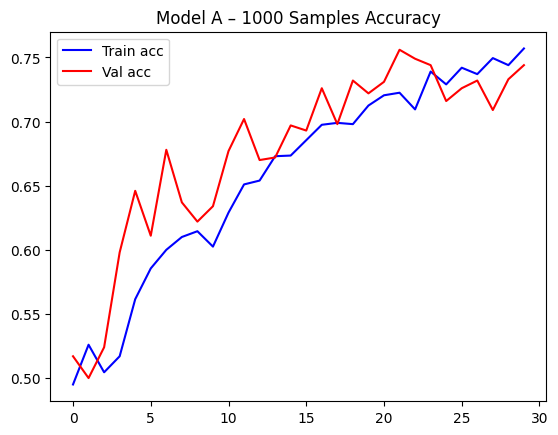

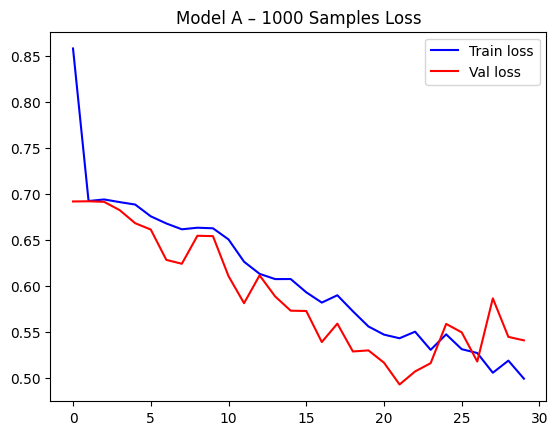

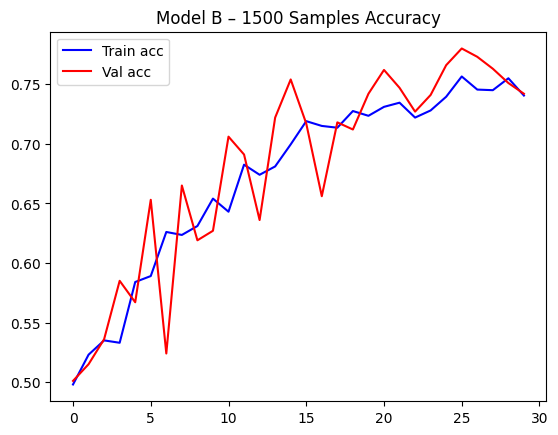

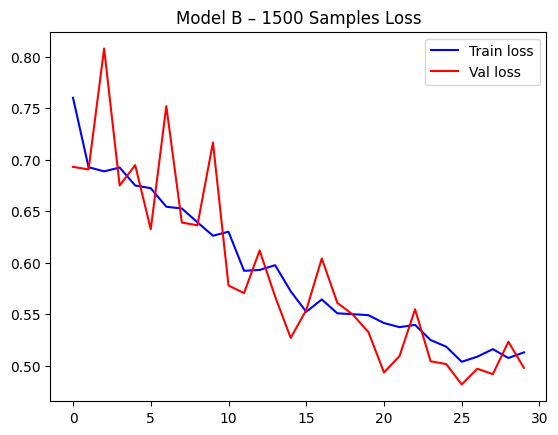

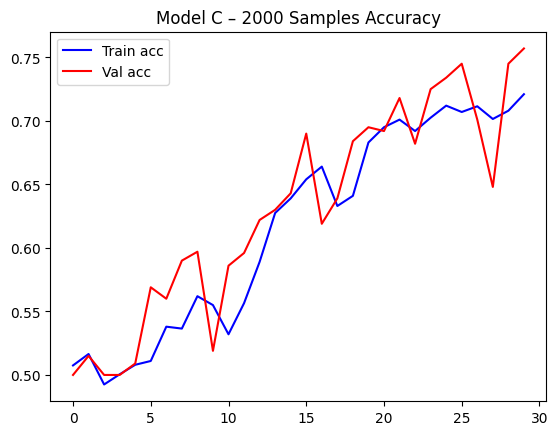

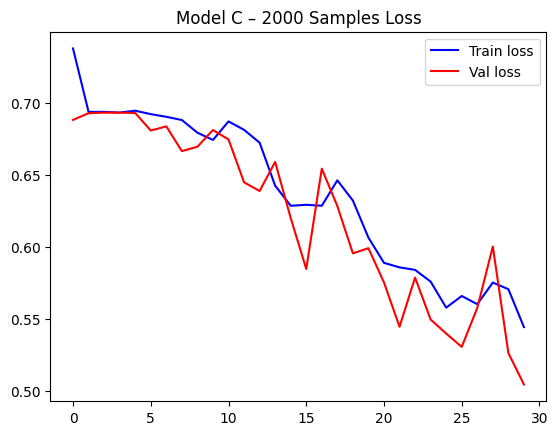

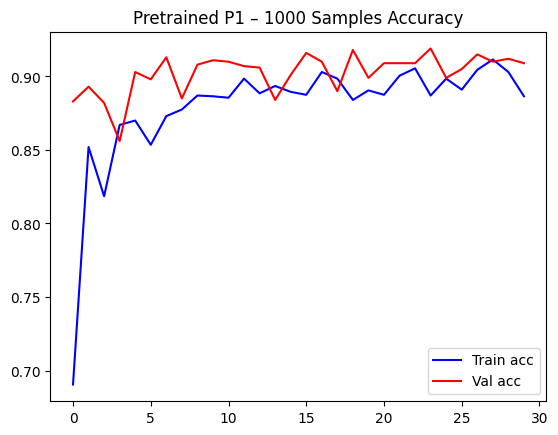

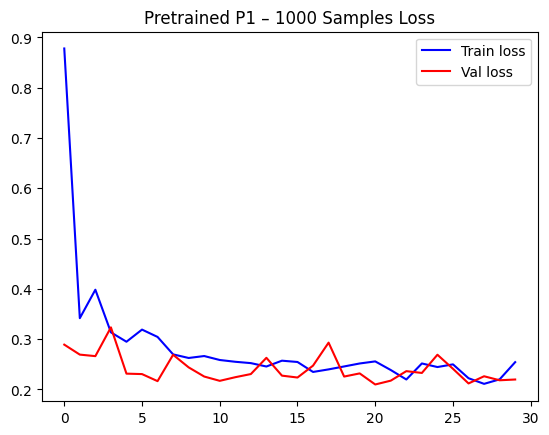

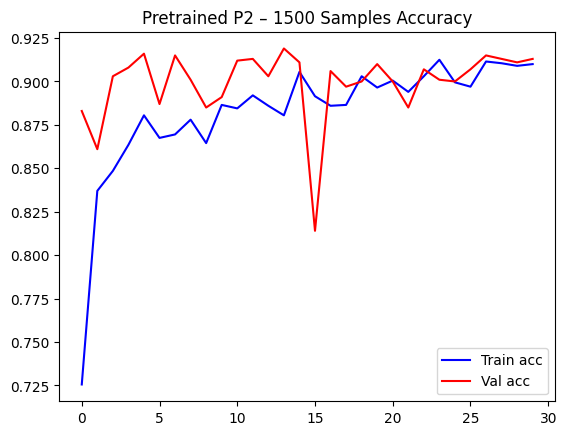

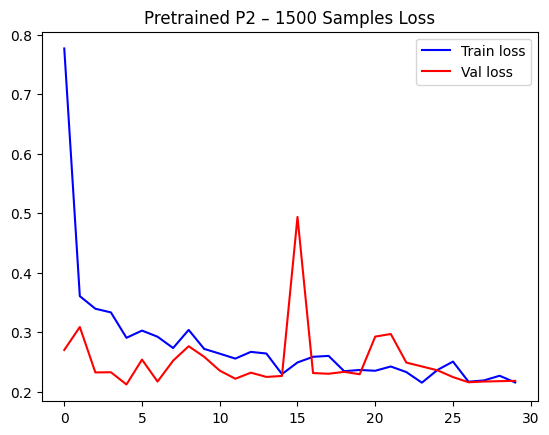

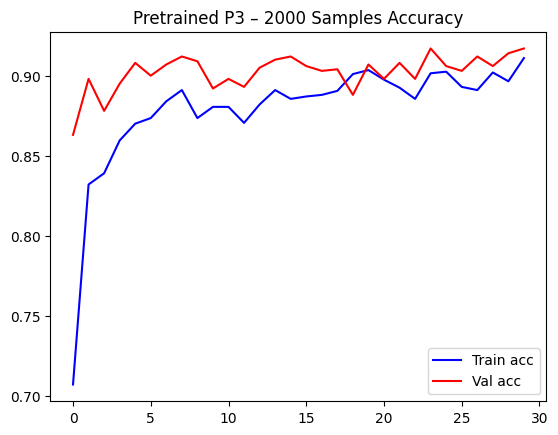

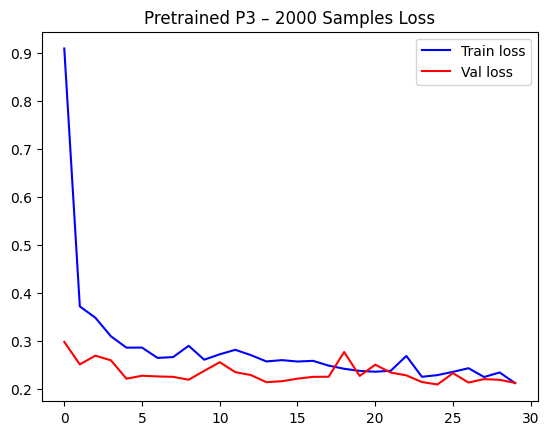

In [ ]:
def visualize_performance(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.figure()
    plt.plot(epochs, acc, 'b', label='Train acc')
    plt.plot(epochs, val_acc, 'r', label='Val acc')
    plt.title(title + " Accuracy")
    plt.legend()

    plt.figure()
    plt.plot(epochs, loss, 'b', label='Train loss')
    plt.plot(epochs, val_loss, 'r', label='Val loss')
    plt.title(title + " Loss")
    plt.legend()
    plt.show()

visualize_performance(history_A, "Model A – 1000 Samples")
visualize_performance(history_B, "Model B – 1500 Samples")
visualize_performance(history_C, "Model C – 2000 Samples")
visualize_performance(history_P1, "Pretrained P1 – 1000 Samples")
visualize_performance(history_P2, "Pretrained P2 – 1500 Samples")
visualize_performance(history_P3, "Pretrained P3 – 2000 Samples")


In [ ]:
def aggregate_results(all_histories, model_labels):
    summary = {}
    for i, history in enumerate(all_histories):
        summary[model_labels[i]] = {
            'Train Acc': history.history['accuracy'][-1],
            'Val Acc': history.history['val_accuracy'][-1],
            'Train Loss': history.history['loss'][-1],
            'Val Loss': history.history['val_loss'][-1],
        }
    return summary

all_histories = [history_A, history_B, history_C, history_P1, history_P2, history_P3]
model_labels = [
    'Model A (Scratch 1000)',
    'Model B (Scratch 1500)',
    'Model C (Scratch 2000)',
    'Pretrained P1 (VGG16 1000)',
    'Pretrained P2 (VGG16 1500)',
    'Pretrained P3 (VGG16 2000)'
]


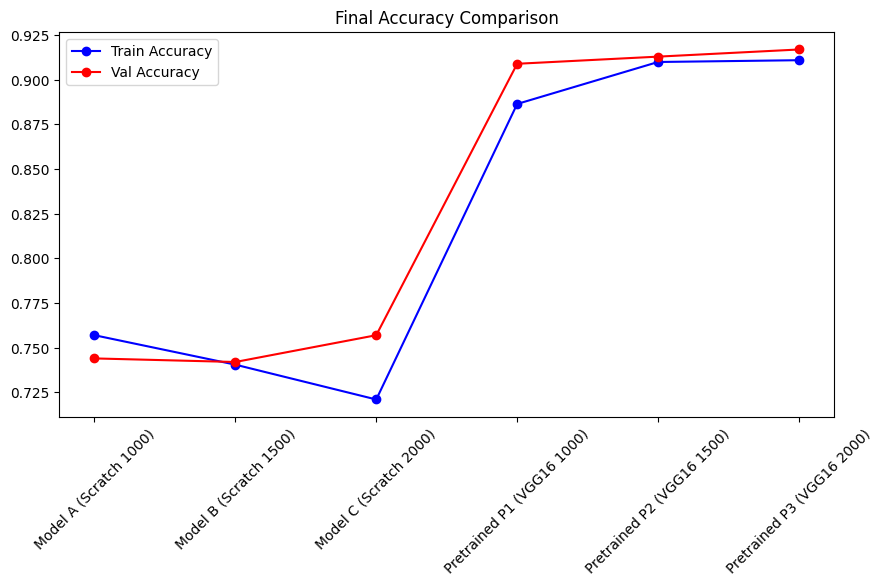

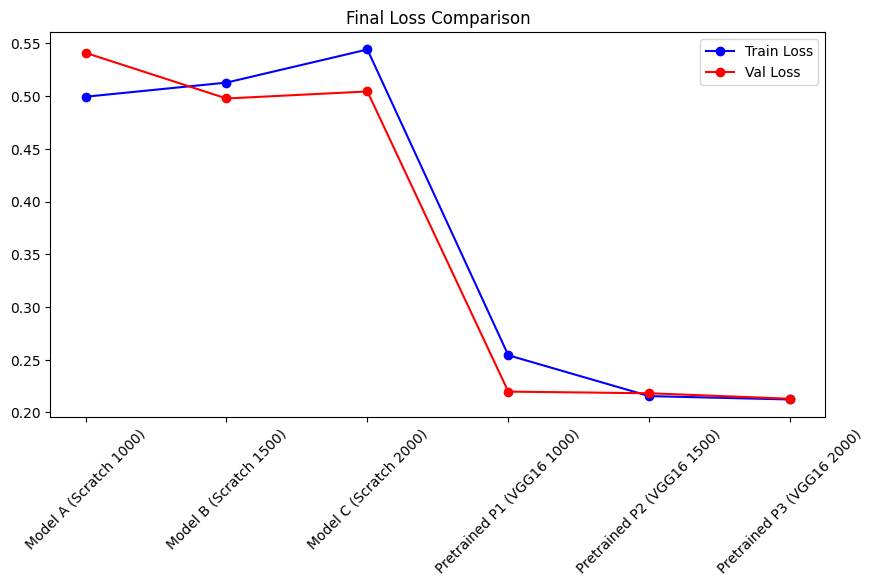

In [ ]:
def compare_models(final_scores):
    model_labels = list(final_scores.keys())
    train_acc = [final_scores[m]['Train Acc'] for m in model_labels]
    val_acc = [final_scores[m]['Val Acc'] for m in model_labels]
    train_loss = [final_scores[m]['Train Loss'] for m in model_labels]
    val_loss = [final_scores[m]['Val Loss'] for m in model_labels]

    plt.figure(figsize=(10,5))
    plt.plot(model_labels, train_acc, 'bo-', label='Train Accuracy')
    plt.plot(model_labels, val_acc, 'ro-', label='Val Accuracy')
    plt.xticks(rotation=45)
    plt.title('Final Accuracy Comparison')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10,5))
    plt.plot(model_labels, train_loss, 'bo-', label='Train Loss')
    plt.plot(model_labels, val_loss, 'ro-', label='Val Loss')
    plt.xticks(rotation=45)
    plt.title('Final Loss Comparison')
    plt.legend()
    plt.show()

final_scores = aggregate_results(all_histories, model_labels)
compare_models(final_scores)
